In [1]:
# @title Import

# !pip install trdg
# !pip install easyocr

# Imports
import copy
import torch
import random
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.auto import tqdm
from IPython.display import HTML, display

# from trdg.generators import GeneratorFromStrings
from PIL import Image
import os
import csv
import string

import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

import easyocr

import editdistance

import re


In [2]:
# @title Set random seed
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [3]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [4]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [5]:
# # @title Generate the dataset (Run once or import it)

# output_dir = "ocr_dataset"
# os.makedirs(output_dir, exist_ok=True)
# csv_file = os.path.join(output_dir, "labels.csv")

# # Define the path to the Stencil font file
# stencil_font_path = "stencils.tff"
# # Check if the font file exists at the specified path
# import os
# if not os.path.isfile(stencil_font_path):
#     raise FileNotFoundError(f"Font file not found: {stencil_font_path}")

# def generate_random_word(length=10):
#     letters = string.ascii_lowercase + ' '
#     return ''.join(random.choice(letters) for i in range(length))

# # Function to save images with labels
# def save_handwritten_text_images(output_dir, csv_file, num_samples=1000):
#     # Generate random words
#     random_words = [generate_random_word(10) for _ in range(num_samples)]

#     # Create generator for handwritten text
#     generator = GeneratorFromStrings(
#         random_words,
#         blur=0,  # No blur
#         random_blur=False,
#         distorsion_type=0,  # No distortion
#         size=32,  # Font size
#         language="en",  # Language set to English
#         fonts=[stencil_font_path]
#     )

#     labels = []
#     fixed_width = 256
#     fixed_height = 56

#     for count, (img, lbl) in enumerate(tqdm(generator, total=num_samples, desc="Creating Datas")):
#         if count >= num_samples:
#           break
#         img = img.convert("L")  # Convert image to grayscale
#         # Resize the image to fixed dimensions
#         img = img.resize((fixed_width, fixed_height), Image.ANTIALIAS)
#         # Save image with related filename
#         img_filename = os.path.join(output_dir, f"{count+1}.png")
#         img.save(img_filename)
#         # print(f"Saved {img_filename} with label {lbl}")
#         labels.append((f"{count+1}.png", lbl))

#     # Save labels to CSV
#     with open(csv_file, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow( ["image_name", "label"])
#         for img_name, label in labels:
#             writer.writerow([img_name, label])

# # Generate and save images
# num_samples = 10000 ## USER 20 000
# save_handwritten_text_images(output_dir, csv_file, num_samples=num_samples)

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("/content/drive/MyDrive/Colab Notebooks/OCR_proj/ocr_dataset.rar", outdir="/content/drive/MyDrive/Colab Notebooks/OCR_proj")

In [8]:
import os

directory = '/home/workstation319/Desktop/python/NMA_codes_n_stuffs/project/datasets/ocr_dataset_simple_v1'
files = os.listdir(directory)
number_of_files = len(files)

print(f"There are {number_of_files} files in {directory}")

There are 10002 files in /home/workstation319/Desktop/python/NMA_codes_n_stuffs/project/datasets/ocr_dataset_simple_v1


In [9]:
import os

directory = '/home/workstation319/Desktop/python/NMA_codes_n_stuffs/project/datasets/ocr_dataset_simple_v1'
non_png_files = []

# List all files in the specified directory
for filename in os.listdir(directory):
    # Check if the file does not end with .png
    if not filename.endswith('.png'):
        non_png_files.append(filename)

# Output the names of non .png files
print("Non .png files in the directory:")
for file in non_png_files:
    print(file)

Non .png files in the directory:
labels_legacy.csv
labels.csv


In [10]:
# Custom shading distortion transformation
class ShadingDistortion:
    def __init__(self, intensity=0.5):  # Increased default intensity for more aggressive shading
        self.intensity = intensity

    def __call__(self, image):
        # Convert PIL image to numpy array
        img_np = np.array(image).astype(np.float32) / 255.0

        # Generate a shading mask to darken the image more aggressively :)
        height, width, channels = img_np.shape
        mask = np.linspace(1 - self.intensity, 0, width)  # Darker shading towards 0
        mask = np.tile(mask, (height, 1))

        # Adjust dimensions to match image array for broadcasting
        mask = mask[:, :, np.newaxis]

        # Apply the shading mask to the image to darken it significantly
        shaded_img = img_np * mask
        shaded_img = np.clip(shaded_img, 0, 1) * 255.0
        shaded_img = shaded_img.astype(np.uint8)

        # Convert numpy array back to PIL image
        return Image.fromarray(shaded_img)
    
def adjust_contrast(image):
    factor = random.uniform(0.1, 2.0)

    # Transforming to adjust contrast
    transform = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.Lambda(lambda img: transforms.functional.adjust_contrast(img, factor)),
        # transforms.ToTensor()
    ])

    adjusted_image = transform(image) # Applying the transform (contrast)

    return adjusted_image

def adjust_sharpness(image):
    factor = random.choice([random.uniform(-3, 0), random.uniform(1, 3)])
    transform = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.Lambda(lambda img: transforms.functional.adjust_sharpness(img, factor)),
        # transforms.ToTensor()
    ])
    adjusted_image = transform(image)
    return adjusted_image


def get_data_loader(tsf=-1, p=0.1):
  # -1 : nothing
  # 0 : rotation
  # 1 : affine tsf
  # 2 Gaussian blur
  # 3 shading distortion
  #4 contrast
  #5 sharpness
  # 6 horzontal flip
  # 7 random perspective
  # 8 equalize
  # @title Data Loader
    class CustomImageDataset(Dataset):
        def __init__(self, csv_file, img_dir, transform=None):
            self.img_labels = pd.read_csv(csv_file)
            self.img_dir = img_dir
            self.transform = transform

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            img_name = self.img_labels.iloc[idx, 0]
            img_path = os.path.join(self.img_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            label = self.img_labels.iloc[idx, 1]

            if self.transform:
                image = self.transform(image)

            return image, label

  # apply corruptions to the preprocess
    float_to_odd_number = lambda float_value: (lambda n: n if n % 2 != 0 else n + 1 if n < float_value else n - 1)(int(round(float_value)))

    corr_list = [
        transforms.RandomRotation(degrees=p*20),
        transforms.RandomAffine(degrees=p*20),
        transforms.GaussianBlur(float_to_odd_number(p*20)),
        ShadingDistortion(intensity=p),
        transforms.Lambda(adjust_contrast),
        transforms.Lambda(adjust_sharpness),
        transforms.RandomHorizontalFlip(p=1), #probability is 1-->it will flip image when called--default 0.5
        transforms.RandomPerspective(distortion_scale=0.6, p=1),#probability is 1-->it will flip image when called--default 0.5
        transforms.RandomEqualize(p=1),
    ]

    # compose transformations including the specified corruption
    if tsf == -1:
      transform = transforms.Compose([
                                    transforms.ToTensor()
                                    ])
    else:
      transform = transforms.Compose([
                                    corr_list[tsf],
                                    transforms.ToTensor()
                                    ])

    # Create an instance of the custom dataset
    csv_file = "/home/workstation319/Desktop/python/NMA_codes_n_stuffs/project/datasets/ocr_dataset_simple_v1/labels_legacy.csv" # Using pathlib to be compatible with all OS's
    img_dir = "/home/workstation319/Desktop/python/NMA_codes_n_stuffs/project/datasets/ocr_dataset_simple_v1"

    dataset = CustomImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

    # Split dataset into training, validation, and test sets
    dataset_size = len(dataset)
    train_size = int(0.20 * dataset_size)
    val_size = int(0.70 * dataset_size)
    test_size = int(0.10 * dataset_size) # reduced otherwise too slow

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders for each dataset
    batch_size = 32  # Adjust batch size as needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [11]:
# @title Initialize easyocr (Only once)
# This needs to run only once to load the model into memory
reader = easyocr.Reader(['en'])

In [12]:
# @title Helper function

# Function to calculate Character Error Rate (CER)
# CER is calculated as the number of character-level errors (insertions, deletions, substitutions)
# divided by the total number of characters in the ground truth text.
def calculate_cer(gt, pred):
    return editdistance.eval(gt, pred) / len(gt)

# Function to calculate Word Error Rate (WER)
def calculate_wer(gt, pred):
    gt_words = gt.split()
    pred_words = pred.split()
    return editdistance.eval(gt_words, pred_words) / len(gt_words)

# Function to evaluate the EasyOCR model and display images with results
def evaluate_easyocr(reader, dataloader):
    total_chars = 0
    total_words = 0
    total_char_errors = 0
    total_word_errors = 0
    correct = 0
    total = 0

    image_count = 0
    max_images_to_display = 1

    for images, labels in tqdm(dataloader, desc="Evaluating"):
        for img, label in zip(images, labels):
            # Ensure the image is in the correct format for EasyOCR
            if isinstance(img, Image.Image):
                img = np.array(img)
            elif isinstance(img, torch.Tensor):
                img = img.numpy().transpose(1, 2, 0) * 255  # Convert tensor to numpy array and scale
                img = img.astype('uint8')

            result = reader.readtext(img)[0]  # Set detail=0 to get only the recognized text
            prediction = result[1].lower()

            # # Calculate accuracy
            # # Replace single spaces with no space
            # prediction = re.sub(r'(?<! ) (?! )', '', prediction)
            # # Replace double spaces with single space
            # prediction = re.sub(r' {2}', ' ', prediction)
            # print(f'Prediction: {prediction.lower()}')
            # print(f'Label: {label.lower()}')
            if prediction == label:
                correct += 1
            total += 1
            # print(f'Correct: {correct}, Total: {total}')

            # Calculate CER
            cer = calculate_cer(label, prediction)
            total_char_errors += cer #* len(label)
            if len(label) != 10 :
              print("err")
            # total_chars += len(label)

            # Calculate WER
            wer = calculate_wer(label, prediction)
            total_word_errors += wer * len(label.split())
            total_words += len(label.split())

            # Display the image with OCR results for the first 10 images
            if image_count < max_images_to_display:
                display_image_with_results(result, img)
                image_count += 1

    accuracy = correct / total
    cer = total_char_errors / total
    wer = total_word_errors / total_words
    return accuracy, cer, wer

# Function to display image with EasyOCR results
def display_image_with_results(res, img):
    # show the image and plot the results
    plt.imshow(img)
    # bbox coordinates of the detected text
    xy = res[0]
    xy1, xy2, xy3, xy4 = xy[0], xy[1], xy[2], xy[3]
    # text results and confidence of detection
    det, conf = res[1], res[2]
    # show time :)
    plt.plot([xy1[0], xy2[0], xy3[0], xy4[0], xy1[0]], [xy1[1], xy2[1], xy3[1], xy4[1], xy1[1]], 'r-')
    plt.text(xy1[0], xy1[1], f'{det} [{round(conf, 2)}]', c='r')
    plt.show()

In [13]:
def test_easyocr(tsf=-1, p_points=10):
    transforms_dict = {
    "-1": "None",
    "0": "rotation",
    "1": "affine tsf",
    "2" : "Gaussian blur",
    "3" : "shading distortion",
    "4" : "contrast",
    "5" : "sharpness",
    "6" : "horzontal flip",
    "7" : "random perspective",
    "8": "equalize"
    }
    used_transform = transforms_dict[str(tsf)]
    for p in np.arange(1e-2, 1-1e-2, 1/p_points):
        train_loader, val_loader, test_loader = get_data_loader(tsf=tsf, p=p)
        test_accuracy, test_cer, test_wer = evaluate_easyocr(reader, test_loader) # test over 1000 images
        print(f'Results for {used_transform} with {p:.4f} intensity')
        print(f'Test Accuracy: {test_accuracy:.4f} \t Test CER: {test_cer:.4f} \t Test WER: {test_wer:.4f}')
        for _ in range(10): print("====", end="")
        print('\n')

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

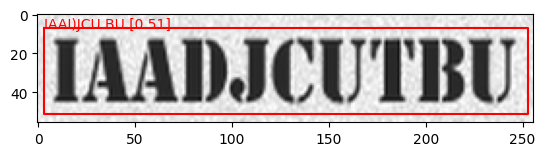

Results for None with 0.0100 intensity
Test Accuracy: 0.1610 	 Test CER: 0.2406 	 Test WER: 0.7408



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

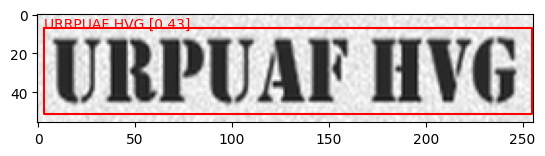

Results for None with 0.1100 intensity
Test Accuracy: 0.1620 	 Test CER: 0.2300 	 Test WER: 0.7201



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

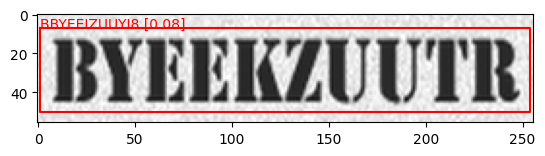

Results for None with 0.2100 intensity
Test Accuracy: 0.1610 	 Test CER: 0.2307 	 Test WER: 0.7153



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

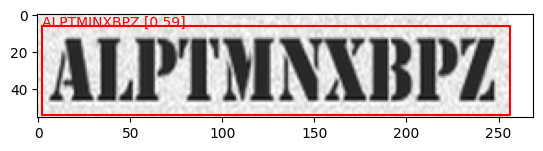

Results for None with 0.3100 intensity
Test Accuracy: 0.1630 	 Test CER: 0.2332 	 Test WER: 0.7222



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

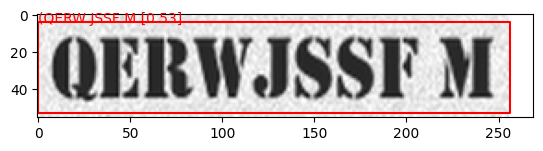

Results for None with 0.4100 intensity
Test Accuracy: 0.1430 	 Test CER: 0.2467 	 Test WER: 0.7513



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

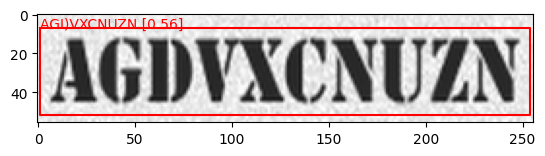

Results for None with 0.5100 intensity
Test Accuracy: 0.1580 	 Test CER: 0.2315 	 Test WER: 0.7419



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

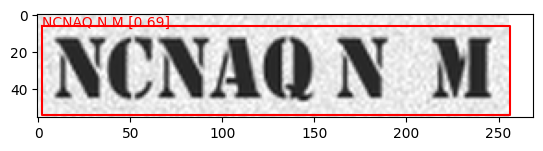

Results for None with 0.6100 intensity
Test Accuracy: 0.1610 	 Test CER: 0.2382 	 Test WER: 0.7354



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

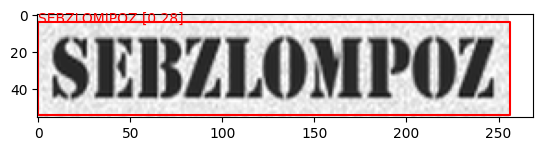

Results for None with 0.7100 intensity
Test Accuracy: 0.1590 	 Test CER: 0.2326 	 Test WER: 0.7361



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

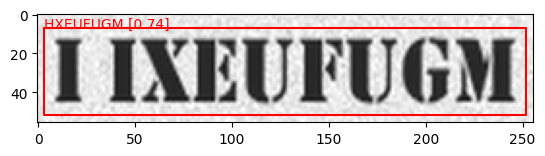

Results for None with 0.8100 intensity
Test Accuracy: 0.1510 	 Test CER: 0.2388 	 Test WER: 0.7328



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

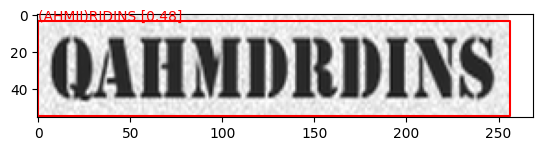

Results for None with 0.9100 intensity
Test Accuracy: 0.1500 	 Test CER: 0.2372 	 Test WER: 0.7457



In [14]:
test_easyocr(tsf=-1, p_points=10)

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

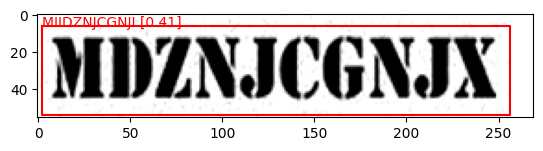

Results for contrast with 0.0100 intensity
Test Accuracy: 0.1410 	 Test CER: 0.2876 	 Test WER: 0.7817



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

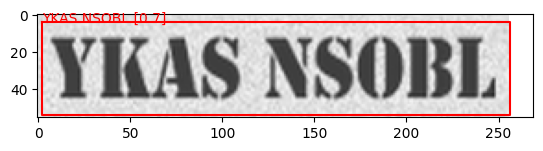

Results for contrast with 0.1100 intensity
Test Accuracy: 0.1340 	 Test CER: 0.2734 	 Test WER: 0.7581



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

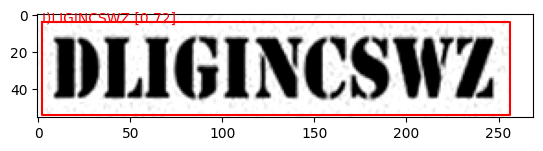

Results for contrast with 0.2100 intensity
Test Accuracy: 0.1170 	 Test CER: 0.2777 	 Test WER: 0.7972



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

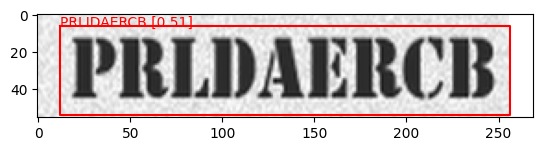

Results for contrast with 0.3100 intensity
Test Accuracy: 0.1160 	 Test CER: 0.2941 	 Test WER: 0.8124



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

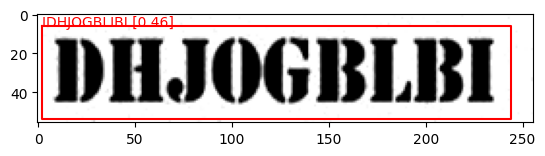

Results for contrast with 0.4100 intensity
Test Accuracy: 0.1380 	 Test CER: 0.2811 	 Test WER: 0.7632



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

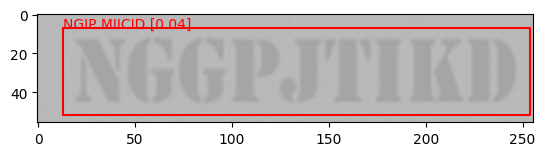

Results for contrast with 0.5100 intensity
Test Accuracy: 0.1280 	 Test CER: 0.2854 	 Test WER: 0.7855



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

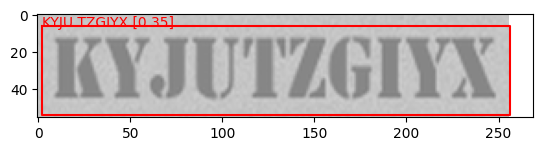

Results for contrast with 0.6100 intensity
Test Accuracy: 0.1040 	 Test CER: 0.2831 	 Test WER: 0.7792



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

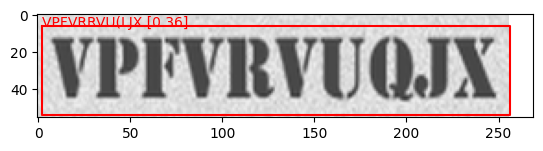

Results for contrast with 0.7100 intensity
Test Accuracy: 0.1430 	 Test CER: 0.2723 	 Test WER: 0.7638



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

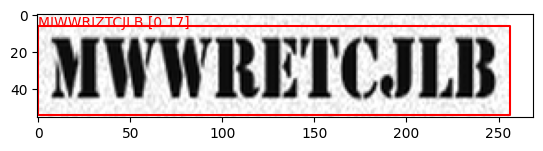

Results for contrast with 0.8100 intensity
Test Accuracy: 0.1140 	 Test CER: 0.2903 	 Test WER: 0.7959



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

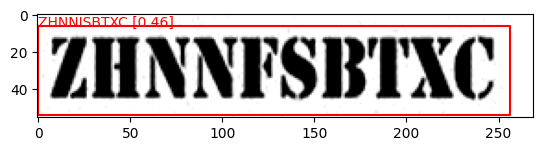

Results for contrast with 0.9100 intensity
Test Accuracy: 0.1330 	 Test CER: 0.2839 	 Test WER: 0.7713



In [15]:
test_easyocr(tsf=4, p_points=10)

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

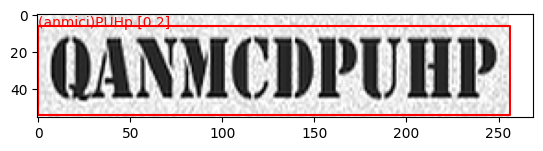

Results for sharpness with 0.0100 intensity
Test Accuracy: 0.1460 	 Test CER: 0.2591 	 Test WER: 0.7853



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

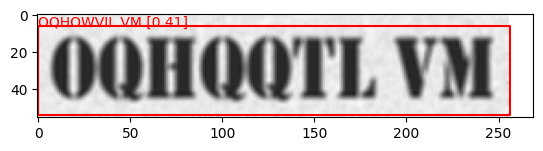

Results for sharpness with 0.1100 intensity
Test Accuracy: 0.1290 	 Test CER: 0.2654 	 Test WER: 0.7799



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

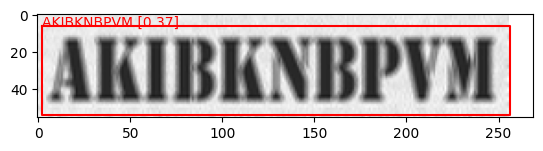

Results for sharpness with 0.2100 intensity
Test Accuracy: 0.1470 	 Test CER: 0.2637 	 Test WER: 0.7648



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

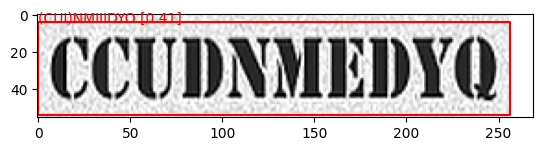

Results for sharpness with 0.3100 intensity
Test Accuracy: 0.1490 	 Test CER: 0.2624 	 Test WER: 0.7733



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

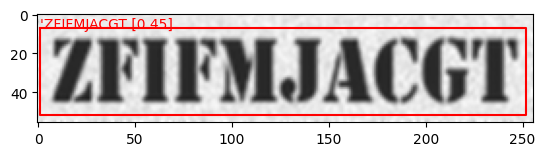

Results for sharpness with 0.4100 intensity
Test Accuracy: 0.1370 	 Test CER: 0.2677 	 Test WER: 0.7836



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

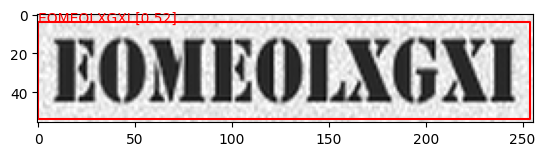

Results for sharpness with 0.5100 intensity
Test Accuracy: 0.1440 	 Test CER: 0.2601 	 Test WER: 0.7857



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

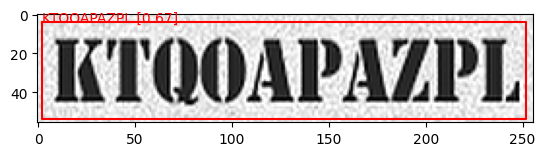

Results for sharpness with 0.6100 intensity
Test Accuracy: 0.1570 	 Test CER: 0.2579 	 Test WER: 0.7688



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

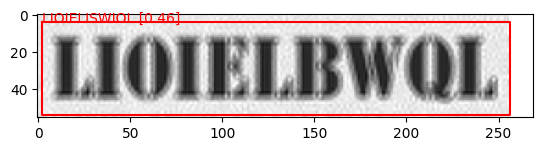

Results for sharpness with 0.7100 intensity
Test Accuracy: 0.1460 	 Test CER: 0.2644 	 Test WER: 0.7798



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

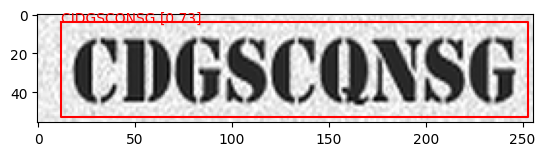

Results for sharpness with 0.8100 intensity
Test Accuracy: 0.1350 	 Test CER: 0.2489 	 Test WER: 0.7952



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

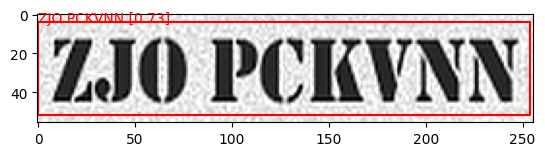

Results for sharpness with 0.9100 intensity
Test Accuracy: 0.1080 	 Test CER: 0.2765 	 Test WER: 0.8005



In [16]:
test_easyocr(tsf=5, p_points=10)

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

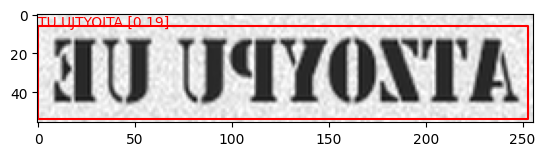

Results for horzontal flip with 0.0100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1090 	 Test WER: 1.0814



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

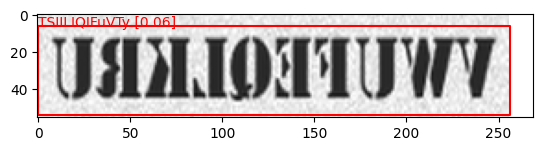

Results for horzontal flip with 0.1100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1116 	 Test WER: 1.0786



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

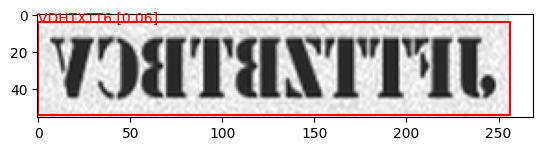

Results for horzontal flip with 0.2100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1047 	 Test WER: 1.0746



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

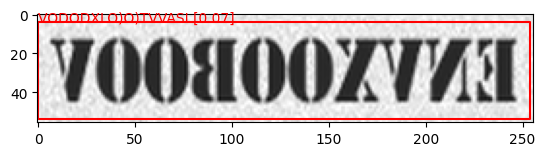

Results for horzontal flip with 0.3100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1244 	 Test WER: 1.0856



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

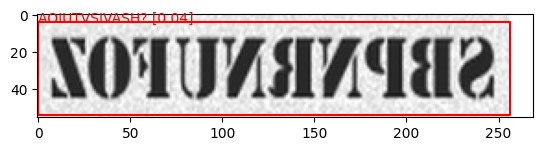

Results for horzontal flip with 0.4100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1245 	 Test WER: 1.0858



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

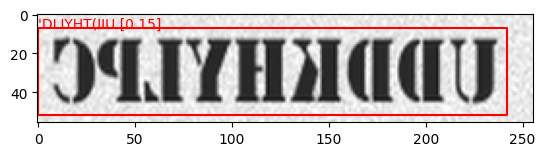

Results for horzontal flip with 0.5100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1161 	 Test WER: 1.0729



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

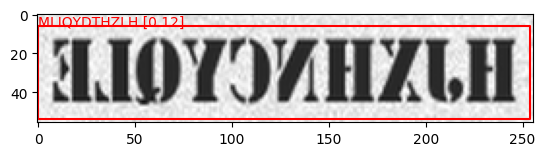

Results for horzontal flip with 0.6100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1150 	 Test WER: 1.0774



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

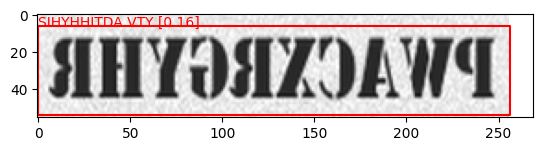

Results for horzontal flip with 0.7100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1194 	 Test WER: 1.0836



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

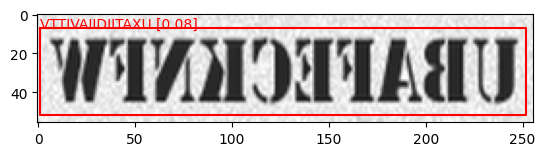

Results for horzontal flip with 0.8100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1084 	 Test WER: 1.0779



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

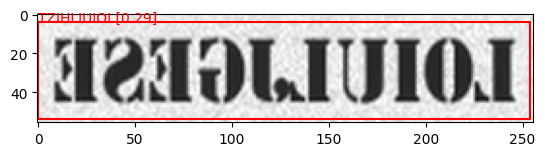

Results for horzontal flip with 0.9100 intensity
Test Accuracy: 0.0000 	 Test CER: 1.1134 	 Test WER: 1.0705



In [17]:
test_easyocr(tsf=6, p_points=10)

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

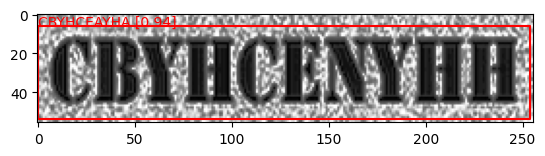

Results for equalize with 0.0100 intensity
Test Accuracy: 0.1270 	 Test CER: 0.2133 	 Test WER: 0.7912



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

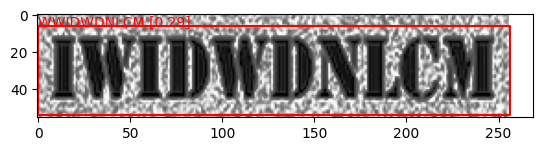

Results for equalize with 0.1100 intensity
Test Accuracy: 0.1390 	 Test CER: 0.2011 	 Test WER: 0.7659



Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

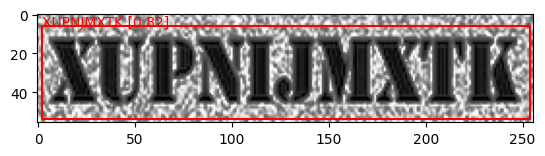

IndexError: list index out of range

In [19]:
test_easyocr(tsf=8, p_points=10)

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

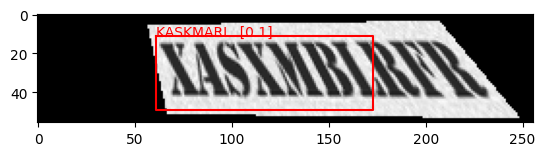

IndexError: list index out of range

In [20]:
test_easyocr(tsf=7, p_points=10)